###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license © 2015 L.A. Barba, C.D. Cooper, G.F. Forsyth.  Based on [CFD Python](https://github.com/barbagroup/CFDPython), © 2013 L.A. Barba, also under CC-BY license.

# Relax and hold steady

This is **Module 5** of the open course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about), titled *"Relax and hold steady: elliptic problems"*. 
If you've come this far in the [#numericalmooc](https://twitter.com/hashtag/numericalmooc) ride, it's time to stop worrying about **time** and relax.  

So far, you've learned to solve problems dominated by convection—where solutions have a directional bias and can form shocks—in [Module 3](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/tree/master/lessons/03_wave/): *"Riding the Wave."* In [Module 4](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/tree/master/lessons/04_spreadout/) (*"Spreading Out"*), we explored diffusion-dominated problems—where solutions spread in all directions. But what about situations where solutions are steady?

Many problems in physics have no time dependence, yet are rich with physical meaning: the gravitational field produced by a massive object, the electrostatic potential of a charge distribution, the displacement of a stretched membrane and the steady flow of fluid through a porous medium ... all these can be modeled by **Poisson's equation**:

\begin{equation}
\nabla^2 u = f
\end{equation}

where the unknown $u$ and the known $f$ are functions of space, in a domain $\Omega$. To find the solution, we require boundary conditions. These could be  Dirichlet boundary conditions, specifying the value of the solution on the boundary,

\begin{equation}
u = b_1 \text{ on } \partial\Omega,
\end{equation}

or Neumann boundary conditions, specifying the normal derivative of the solution on the boundary,

\begin{equation}
\frac{\partial u}{\partial n} = b_2 \text{ on } \partial\Omega.
\end{equation}

A boundary-value problem consists of finding $u$, given the above information. Numerically, we can do this using *relaxation methods*, which start with an initial guess for $u$ and then iterate towards the solution. Let's find out how!

## Laplace's equation

The particular case of $f=0$ (homogeneous case) results in Laplace's equation:

\begin{equation}
\nabla^2 u = 0
\end{equation}

For example, the equation for steady, two-dimensional heat conduction is:

\begin{equation}
\frac{\partial ^2 T}{\partial x^2} + \frac{\partial ^2 T}{\partial y^2} = 0
\end{equation}

This is similar to the model we studied in [lesson 3](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_03_Heat_Equation_2D_Explicit.ipynb) of **Module 4**, but without the time derivative: i.e., for a temperature $T$ that has reached steady state. The Laplace equation models the equilibrium state of a system under the supplied boundary conditions.

The study of solutions to Laplace's equation is called *potential theory*, and the solutions themselves are often potential fields. Let's use $p$ from now on to represent our generic dependent variable, and write Laplace's equation again (in two dimensions):

\begin{equation}
\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0
\end{equation}

Like in the diffusion equation of the previous course module, we discretize the second-order derivatives with *central differences*. You should be able to write down a second-order central-difference formula by heart now! On a two-dimensional Cartesian grid, it gives:

\begin{equation}
\frac{p_{i+1, j}  - 2p_{i,j}  + p_{i-1,j} }{\Delta x^2} + \frac{p_{i,j+1}  - 2p_{i,j}  + p_{i, j-1} }{\Delta y^2} = 0
\end{equation}

When $\Delta x = \Delta y$, we end up with the following equation:


\begin{equation}
p_{i+1, j}   + p_{i-1,j} + p_{i,j+1}  + p_{i, j-1}- 4 p_{i,j} = 0
\end{equation}

This tells us that the Laplacian differential operator at grid point $(i,j)$ can be evaluated discretely using the value of $p$ at that point (with a factor $-4$) and the four neighboring points to the left and right, above and below grid point $(i,j)$.

The stencil of the discrete Laplacian operator is shown in Figure 1. It is typically called the *five-point stencil*, for obvious reasons.


<img src="./figures/laplace.svg">

#### Figure 1: Laplace five-point stencil.

The discrete equation above is valid for every interior point in the domain. If we write the equations for *all* interior points, we have a linear system of algebraic equations. We *could* solve the linear system directly (e.g., with Gaussian elimination), but we can be more clever than that!

Notice that the coefficient matrix of such a linear system has mostly zeroes. For a uniform spatial grid, the matrix is *block diagonal*: it has diagonal blocks that are tridiagonal with $-4$ on the main diagonal and $1$ on two off-center diagonals, and two more diagonals with $1$. All of the other elements are zero. Iterative methods are particularly suited for a system with this structure, and save us from storing all those zeroes.

We will start with an initial guess for the solution, $p_{i,j}^{0}$, and use the discrete Laplacian to get an update, $p_{i,j}^{1}$, then continue on computing $p_{i,j}^{k}$ until we're happy.  Note that $k$ is _not_ a time index here, but an index corresponding to the number of iterations we perform in the *relaxation scheme*.  

At each iteration, we compute updated values $p_{i,j}^{k+1}$ in a (hopefully) clever way so that they converge to a set of values satisfying Laplace's equation. The system will reach equilibrium only as the number of iterations tends to $\infty$, but we can approximate the equilibrium state by iterating until the change between one iteration and the next is *very* small.  

The most intuitive method of iterative solution is known as the [**Jacobi method**](https://en.wikipedia.org/wiki/Jacobi_method), in which the values at the grid points are replaced by the corresponding weighted averages:


\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k}_{i,j-1} + p^k_{i,j+1} + p^{k}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

This method does indeed converge to the solution of Laplace's equation. Thank you Professor Jacobi!



##### Challenge task

Grab a piece of paper and write out the coefficient matrix for a discretization with 7 grid points in the $x$ direction (5 interior points) and 5 points in the $y$ direction (3 interior). The system should have 15 unknowns, and the coefficient matrix three diagonal blocks. Assume prescribed Dirichlet boundary conditions on all sides (not necessarily zero).

### Boundary conditions and relaxation

Suppose we want to model steady-state heat transfer on (say) a computer chip with one side insulated (zero Neumann BC), two sides held at a fixed temperature (Dirichlet condition) and one side touching a component that has a sinusoidal distribution of temperature.
We would need to solve Laplace's equation with boundary conditions like

\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y = H.
  \end{gathered}
\end{equation}


We'll take $L=1$ and $H=1$ for the sizes of the domain in the $x$ and $y$ directions.

One of the defining features of elliptic PDEs is that they are "driven" by the boundary conditions.  In the iterative solution of Laplace's equation, boundary conditions are set and **the solution relaxes** from an initial guess to join the boundaries together smoothly, given those conditions.  Our initial guess will be $p=0$ everywhere. Now, let's relax!

First, we import our usual smattering of libraries (plus a few new ones!)

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

To visualize 2D data, we can use [`pyplot.imshow()`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow), like we've done before, but a 3D plot can sometimes show a more intuitive view the solution. Or it's just prettier!

Be sure to enjoy the many examples of 3D plots in the `mplot3d` section of the [Matplotlib Gallery](http://matplotlib.org/gallery.html#mplot3d).  

We'll import the `Axes3D` library from Matplotlib and also grab the `cm` package, which provides different colormaps for visualizing plots.  

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Let's define a function for setting up our plotting environment, to avoid repeating this set-up over and over again. It will save us some typing.


In [3]:
def plot_3D(x, y, p):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)


##### Note 
This plotting function uses *Viridis*, a new (and _awesome_) colormap available in Matplotlib versions 1.5 and greater.  If you see an error when you try to plot using <tt>cm.viridis</tt>, just update Matplotlib using <tt>conda</tt> or <tt>pip</tt>.

### Analytical solution

The Laplace equation with the boundary conditions listed above has an analytical solution, given by

\begin{equation}
p(x,y) = \frac{\sinh \left( \frac{\frac{3}{2} \pi y}{L}\right)}{\sinh \left(  \frac{\frac{3}{2} \pi H}{L}\right)} \sin \left( \frac{\frac{3}{2} \pi x}{L} \right)
\end{equation}

where $L$ and $H$ are the length of the domain in the $x$ and $y$ directions, respectively.

We previously used `numpy.meshgrid` to plot our 2D solutions to the heat equation in Module 4.  Here, we'll use it again as a plotting aid. Always useful, `linspace` creates 1-row arrays of equally spaced numbers: it helps for defining $x$ and $y$ axes in line plots, but now we want the analytical solution plotted for every point in our domain.  To do this, we'll use in the analytical solution the 2D arrays generated by `numpy.meshgrid`.

In [4]:
def p_analytical(x, y):
    X, Y = numpy.meshgrid(x,y)
    
    p_an = numpy.sinh(1.5*numpy.pi*Y / x[-1]) /\
    (numpy.sinh(1.5*numpy.pi*y[-1]/x[-1]))*numpy.sin(1.5*numpy.pi*X/x[-1])
    
    return p_an

Ok, let's try out the analytical solution and use it to test the `plot_3D` function we wrote above.  

In [5]:
nx = 41
ny = 41

x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

p_an = p_analytical(x,y)

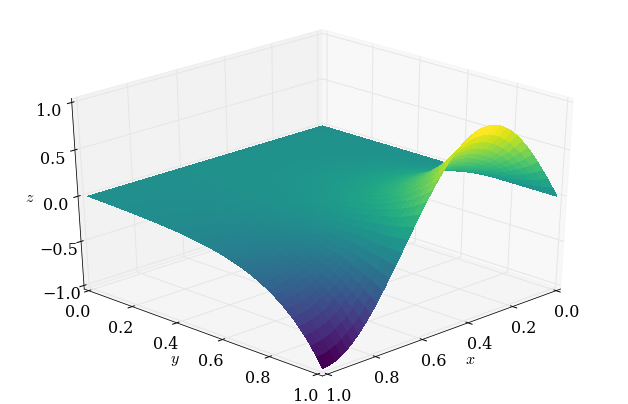

In [6]:
plot_3D(x,y,p_an)

It worked!  This is what the solution *should* look like when we're 'done' relaxing. (And isn't viridis a cool colormap?) 

### How long do we iterate?

We noted above that there is no time dependence in the Laplace equation.  So it doesn't make a lot of sense to use a `for` loop with `nt` iterations, like we've done before.

Instead, we can use a `while` loop that continues to iteratively apply the relaxation scheme until the difference between two successive iterations is small enough.  

But how small is small enough?  That's a good question.  We'll try to work that out as we go along.  

To compare two successive potential fields, a good option is to use the [L2 norm][1] of the difference.  It's defined as

\begin{equation}
|\textbf{x}| = \sqrt{\sum_{i=0, j=0}^k \left|p^{k+1}_{i,j} - p^k_{i,j}\right|^2}
\end{equation}

But there's one flaw with this formula.  We are summing the difference between successive iterations at each point on the grid. So what happens when the grid grows? (For example, if we're refining the grid, for whatever reason.) There will be more grid points to compare and so more contributions to the sum. The norm will be a larger number just because of the grid size!

That doesn't seem right.  We'll fix it by normalizing the norm, dividing the above formula by the norm of the potential field at iteration $k$. 

For two successive iterations, the relative L2 norm is then calculated as

\begin{equation}
|\textbf{x}| = \frac{\sqrt{\sum_{i=0, j=0}^k \left|p^{k+1}_{i,j} - p^k_{i,j}\right|^2}}{\sqrt{\sum_{i=0, j=0}^k \left|p^k_{i,j}\right|^2}}
\end{equation}

Our Python code for this calculation is a one-line function:

[1]:http://en.wikipedia.org/wiki/Norm_%28mathematics%29#Euclidean_norm

In [7]:
def L2_error(p, pn):
    return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

Now, let's define a function that will apply Jacobi's method for Laplace's equation.  Three of the boundaries are Dirichlet boundaries and so we can simply leave them alone.  Only the Neumann boundary needs to be explicitly calculated at each iteration.  

In [8]:
def laplace2d(p, l2_target):
    '''Iteratively solves the Laplace equation using the Jacobi method
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    l2_target: float
        target for the difference between consecutive solutions
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])
        
        ##Neumann B.C. along x = L
        p[1:-1, -1] = p[1:-1, -2]
        l2norm = L2_error(p, pn)
     
    return p

##### Rows and columns, and index order

Recall that in the [2D explicit heat equation](http://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_03_Heat_Equation_2D_Explicit.ipynb) we stored data with the $y$ coordinates corresponding to the rows of the array and $x$ coordinates on the columns (this is just a code design decision!). We did that so that a plot of the 2D-array values would have the natural ordering, corresponding to the physical domain ($y$ coordinate in the vertical). 

We'll follow the same convention here (even though we'll be plotting in 3D, so there's no real reason), just to be consistent. Thus, $p_{i,j}$ will be stored in array format as `p[j,i]`. Don't be confused by this.


### Let's relax!

The initial values of the potential field are zero everywhere (initial guess), except at the boundary: 

$$p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y=H$$

To initialize the domain, `numpy.zeros` will handle everything except that one Dirichlet condition. Let's do it!

In [9]:
##variable declarations
nx = 41
ny = 41


##initial conditions
p = numpy.zeros((ny,nx)) ##create a XxY vector of 0's


##plotting aids
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

##Dirichlet boundary conditions
p[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])


Now let's visualize the initial conditions using the `plot_3D` function, just to check we've got it right.


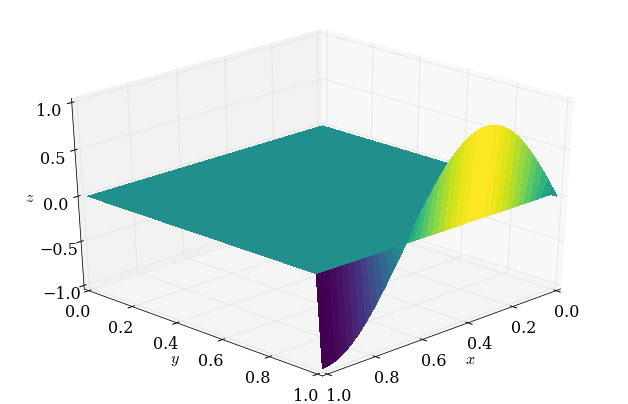

In [10]:
plot_3D(x, y, p)

The `p` array is equal to zero everywhere, except along the boundary $y = 1$.  Hopefully you can see how the relaxed solution and this initial condition are related.  

Now, run the iterative solver with a target L2-norm difference between successive iterations of $10^{-8}$.

In [11]:
p = laplace2d(p.copy(), 1e-8)


Let's make a gorgeous plot of the final field using the newly minted `plot_3D` function.

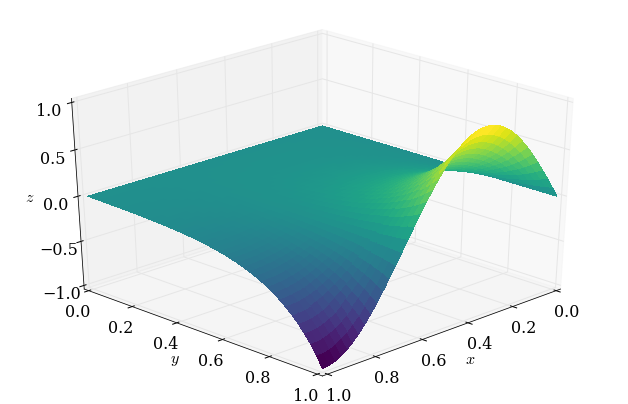

In [12]:
plot_3D(x,y,p)

Awesome!  That looks pretty good.  But we'll need more than a simple visual check, though. The "eyeball metric" is very forgiving!

## Convergence analysis

### Convergence, Take 1

We want to make sure that our Jacobi function is working properly.  Since we have an analytical solution, what better way than to do a grid-convergence analysis?  We will run our solver for several grid sizes and look at how fast the L2 norm of the difference between consecutive iterations decreases.

Let's make our lives easier by writing a function to "reset" the initial guess for each grid so we don't have to keep copying and pasting them.

In [13]:
def laplace_IG(nx):
    '''Generates initial guess for Laplace 2D problem for a 
    given number of grid points (nx) within the domain [0,1]x[0,1]
    
    Parameters:
    ----------
    nx: int
        number of grid points in x (and implicitly y) direction
        
    Returns:
    -------
    p: 2D array of float
        Pressure distribution after relaxation
    x: array of float
        linspace coordinates in x
    y: array of float
        linspace coordinates in y
    '''

    ##initial conditions
    p = numpy.zeros((nx,nx)) ##create a XxY vector of 0's

    ##plotting aids
    x = numpy.linspace(0,1,nx)
    y = x

    ##Dirichlet boundary conditions
    p[:,0] = 0
    p[0,:] = 0
    p[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])
    
    return p, x, y

Now run Jacobi's method on the Laplace equation using four different grids, with the same exit criterion of $10^{-8}$ each time. Then, we look at the error versus the grid size in a log-log plot. What do we get?

In [14]:
nx_values = [11, 21, 41, 81]
l2_target = 1e-8

error = numpy.empty_like(nx_values, dtype=numpy.float)


for i, nx in enumerate(nx_values):
    p, x, y = laplace_IG(nx)
    
    p = laplace2d(p.copy(), l2_target)
    
    p_an = p_analytical(x, y)
    
    error[i] = L2_error(p, p_an)
    

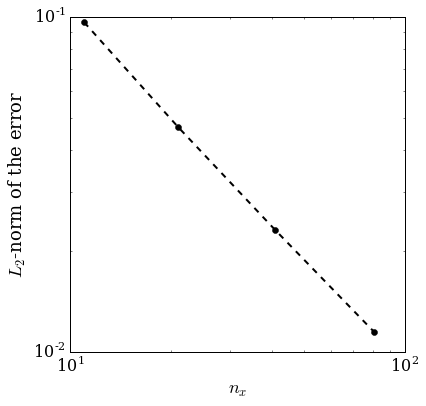

In [15]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)

pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

Hmm. That doesn't look like 2nd-order convergence, but we're using second-order finite differences.  *What's going on?*  The culprit is the boundary conditions. Dirichlet conditions are order-agnostic (a  set value is a set value), but the scheme we used for the Neumann boundary condition is 1st-order.  

Remember when we said that the boundaries drive the problem?  One boundary that's 1st-order completely tanked our spatial convergence.  Let's fix it!

### 2nd-order Neumann BCs

Up to this point, we have used the first-order approximation of a derivative to satisfy Neumann B.C.'s. For a boundary located at $x=0$ this reads,

\begin{equation}
\frac{p^{k+1}_{1,j} - p^{k+1}_{0,j}}{\Delta x} = 0
\end{equation}

which, solving for $p^{k+1}_{0,j}$ gives us

\begin{equation}
p^{k+1}_{0,j} = p^{k+1}_{1,j}
\end{equation}

Using that Neumann condition will limit us to 1st-order convergence.  Instead, we can start with a 2nd-order approximation (the central-difference approximation):

\begin{equation}
\frac{p^{k+1}_{1,j} - p^{k+1}_{-1,j}}{2 \Delta x} = 0
\end{equation}

That seems problematic, since there is no grid point $p^{k}_{-1,j}$.  But no matter … let's carry on. According to the 2nd-order approximation,

\begin{equation}
p^{k+1}_{-1,j} = p^{k+1}_{1,j}
\end{equation}

Recall the finite-difference Jacobi equation with $i=0$:

\begin{equation}
p^{k+1}_{0,j} = \frac{1}{4} \left(p^{k}_{0,j-1} + p^k_{0,j+1} + p^{k}_{-1,j} + p^k_{1,j} \right)
\end{equation}

Notice that the equation relies on the troublesome (nonexistent) point $p^k_{-1,j}$, but according to the equality just above, we have a value we can substitute, namely $p^k_{1,j}$. Ah! We've completed the 2nd-order Neumann condition:

\begin{equation}
p^{k+1}_{0,j} = \frac{1}{4} \left(p^{k}_{0,j-1} + p^k_{0,j+1} + 2p^{k}_{1,j} \right)
\end{equation}

That's a bit more complicated than the first-order version, but it's relatively straightforward to code.

##### Note 

Do not confuse $p^{k+1}_{-1,j}$ with <tt>p[-1]</tt>:
<tt>p[-1]</tt> is a piece of Python code used to refer to the last element of a list or array named <tt>p</tt>.  $p^{k+1}_{-1,j}$ is a 'ghost' point that describes a position that lies outside the actual domain.

### Convergence, Take 2

We can copy the previous Jacobi function and replace only the line implementing the Neumann boundary condition.  

##### Careful!
Remember that our problem has the Neumann boundary located at $x = L$ and not $x = 0$ as we assumed in the derivation above.

In [16]:
def laplace2d_neumann(p, l2_target):
    '''Iteratively solves the Laplace equation using the Jacobi method
    with second-order Neumann boundary conditions
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    l2_target: float
        target for the difference between consecutive solutions
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])
        
        ##2nd-order Neumann B.C. along x = L
        p[1:-1,-1] = .25 * (2*pn[1:-1,-2] + pn[2:, -1] + pn[:-2, -1])
        
        l2norm = L2_error(p, pn)
     
    return p

Again, this is the exact same code as before, but now we're running the Jacobi solver with a 2nd-order Neumann boundary condition.  Let's do a grid-refinement analysis, and plot the error versus the grid spacing.

In [17]:
nx_values = [11, 21, 41, 81]
l2_target = 1e-8

error = numpy.empty_like(nx_values, dtype=numpy.float)


for i, nx in enumerate(nx_values):
    p, x, y = laplace_IG(nx)
    
    p = laplace2d_neumann(p.copy(), l2_target)
    
    p_an = p_analytical(x, y)
    
    error[i] = L2_error(p, p_an)

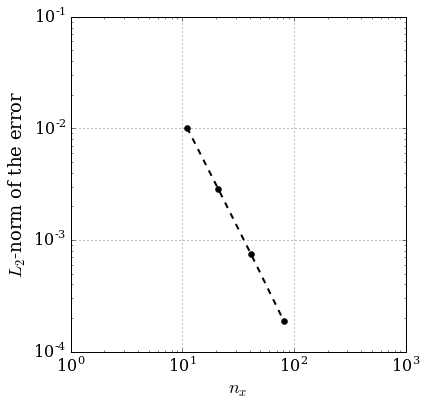

In [18]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)

pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

Nice!  That's much better.  It might not be *exactly* 2nd-order, but it's awfully close. (What is ["close enough"](http://ianhawke.github.io/blog/close-enough.html) in regards to observed convergence rates is a thorny question.)

Now, notice from this plot that the error on the finest grid is around $0.0002$. Given this, perhaps we didn't need to continue iterating until a target difference between two solutions of $10^{-8}$. The spatial accuracy of the finite difference approximation is much worse than that! But we didn't know it ahead of time, did we? That's the "catch 22" of iterative solution of systems arising from discretization of PDEs.

## Final word

The Jacobi method is the simplest relaxation scheme to explain and to apply. It is also the *worst* iterative solver! In practice, it is seldom used on its own as a solver, although it is useful as a smoother with multi-grid methods. As we will see in the [third lesson](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_03_Iterate.This.ipynb) of this module, there are much better iterative methods! But first, let's play with [Poisson's equation](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_02_2D.Poisson.Equation.ipynb).

In [19]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())